In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
df1 = pd.read_csv("bfx_formatted_trades.csv")

In [34]:
df1['timestamp'] = pd.to_datetime(df1['timestamp'])

In [35]:
# for easier data minipulation and visaulization, multiply side b qty by -1
df1['new_qty']=np.where(df1['side']=='a',df1['qty'],df1['qty']*(-1))
df1=df1.set_index('timestamp')

In [36]:
df2 = pd.read_csv("bin_formatted_trades.csv")
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
# for easier data minipulation and visaulization, multiply side b qty by -1
df2['new_qty']=np.where(df2['side']=='a',df2['qty'],df2['qty']*(-1))

In [37]:
df3 = pd.read_csv("okex_formatted_trades.csv")
df3['timestamp'] = pd.to_datetime(df3['timestamp'])
# for easier data minipulation and visaulization, multiply side b qty by -1
df3['new_qty']=np.where(df3['side']=='a',df3['qty'],df3['qty']*(-1))
df3=df3.set_index('timestamp')

In [48]:
df1['EMA5']=pd.ewma(df1['new_qty'], span=5)
df2['EMA5']=pd.ewma(df2['new_qty'], span=5)
df3['EMA5']=pd.ewma(df3['new_qty'], span=5)

/Users/415350992/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=5,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.
/Users/415350992/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=5,min_periods=0,adjust=True,ignore_na=False).mean()
  
/Users/415350992/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=5,min_periods=0,adjust=True,ignore_na=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
df1['exchange_id']=1
df2['exchange_id']=2
df3['exchange_id']=3

In [50]:
df1=df1.reset_index()
df2=df2.reset_index()
df3=df3.reset_index()

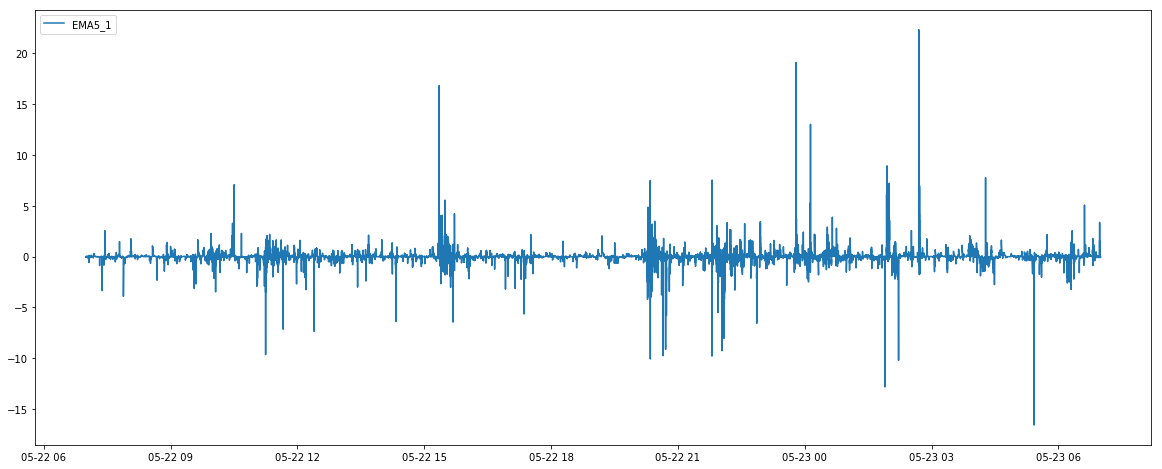

In [104]:
plt.figure(figsize=(20,8))
plt.plot(df1.timestamp, df1.EMA5, label='EMA5_1')
plt.legend(loc='upper left')
plt.show()

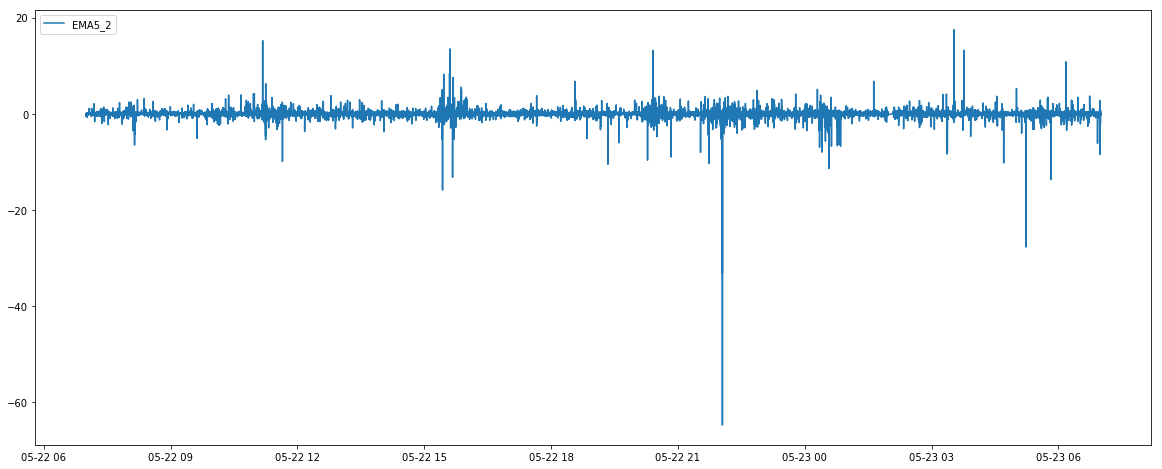

In [105]:
plt.figure(figsize=(20,8))
plt.plot(df2.timestamp, df2.EMA5, label='EMA5_2')
plt.legend(loc='upper left')
plt.show()

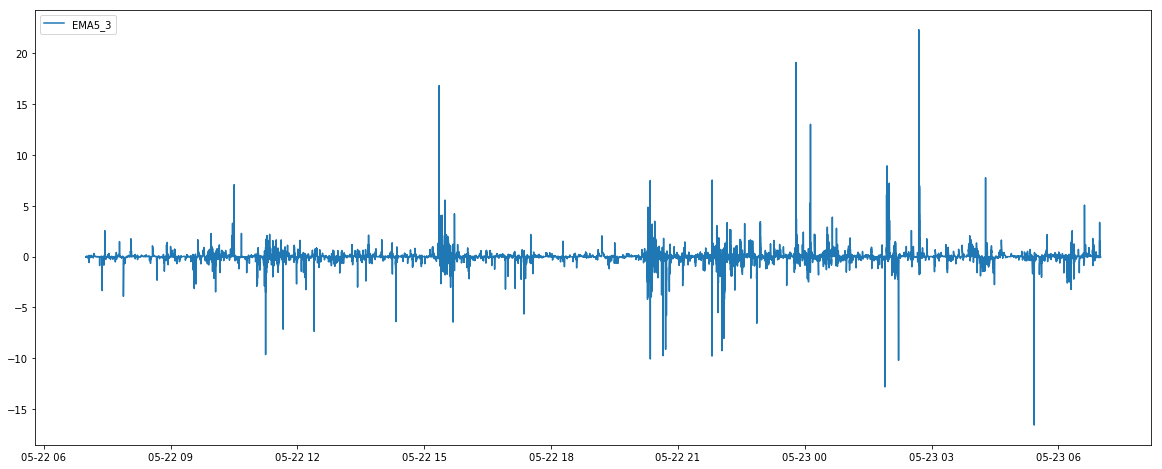

In [106]:
plt.figure(figsize=(20,8))
plt.plot(df1.timestamp, df1.EMA5, label='EMA5_3')
plt.legend(loc='upper left')
plt.show()

In [107]:
df_all = df1.append(df2).append(df3)
df_all=df_all.drop(['index'],axis=1)
df_all=df_all.sort_values(by=['timestamp'])
df_all=df_all.reset_index(drop=True)

In [112]:
# best result so far
# EMA5 threshold algorithm
from collections import defaultdict
from datetime import timedelta
import math
from datetime import datetime
balance = 25000
BTC = 0
# temp balance and temp BTC are the balance and BTC assuming all attempts are successful immediately
temp_balance = 25000
temp_BTC = 0

bid_price = 0
end_time = '2019-05-23 07:00:00'
fmt = '%Y-%m-%d %H:%M:%S'
tstamp_end_time = datetime.strptime('2019-05-23 07:00:00', fmt)
bids = []
asks = []
# initialize the three prices dictionary
three_prices = {}
three_prices[1] = 0
three_prices[2] = 0
three_prices[3] = 0
for index, row in df_all.iterrows():
    # prevent excessive bids/asks
    if(len(bids) > 100):
        break
    timestamp = str(row['timestamp'])
    add_one_millisec = str(row['timestamp'] + timedelta(seconds=0.001))
    EMA5 = row['EMA5']
    price = row['price']
    exchange_id = row['exchange_id']
    side = row['side']
    date = add_one_millisec.split(' ')[0]
    time = add_one_millisec.split(' ')[1]
    three_prices[exchange_id] = price
    current_highest = three_prices[max(three_prices, key=three_prices.get)]
    current_lowest = three_prices[min(three_prices, key=three_prices.get)]
    # check if past bids would be successful at this row
#     if(side == 'a'):
#         for i in range(0, len(bids)):
#             # that bid is successful
#             if(bids[i][0]<row['timestamp'] and bids[i][1] == exchange_id and bids[i][2] >= price and bids[i][3] == 'unsuccessful' and balance >= 0.5 * price):
#                 bids[i][3] = 'successful'
#                 BTC += 0.5
#                 balance -= price * 0.5
#                 break
#     # check if past asks would be successful at this row
#     elif(side == 'b'):
#         for i in range(0, len(asks)):
#             # that ask is sucessful
#             if(asks[i][0]<row['timestamp'] and asks[i][1] == exchange_id and asks[i][2] <= price and asks[i][3] == 'unsuccessful' and BTC > 0):
#                 asks[i][3] = 'successful'
#                 BTC -= 0.5
#                 balance += price * 0.5
#                 break

    # bid attempt
    maximum_can_buy = math.floor(temp_balance / (price * 0.5))
    if((three_prices[1] > 0 and three_prices[2] > 0 and three_prices[3] > 0) and  # check if the current prices have been loaded
       # exchange_id in [1, 3] because it seems only exchange 1 and 2 generate good signals
       ((EMA5 >= 15 and exchange_id in [1, 3]) or current_highest - 50 >= current_lowest) and
            maximum_can_buy > 0):
        bid_exchange_id = min(three_prices, key=three_prices.get)

        if(maximum_can_buy >= 1):
            bid_price = current_lowest

        for i in range(0, maximum_can_buy):
            bids.append([row['timestamp'], bid_exchange_id,
                         bid_price, 'unsuccessful'])
            print(date + 'T' + time + 'Z,' +
                  str(bid_exchange_id) + ',' + str(bid_price) + ',b')

        temp_balance -= bid_price * maximum_can_buy * 0.5
        temp_BTC += 0.5 * maximum_can_buy

    # ask attempt
    maximum_can_sell = int(temp_BTC * 2)
    if((current_highest - 50 >= bid_price or (tstamp_end_time - row['timestamp']).total_seconds() <= 60) and
       maximum_can_sell > 0):
        bid_exchange_id = max(three_prices, key=three_prices.get)

        for i in range(0, maximum_can_sell):
            asks.append([row['timestamp'], bid_exchange_id,
                         current_highest, 'unsuccessful'])
            print(date + 'T' + time + 'Z,' +
                  str(bid_exchange_id) + ',' + str(current_highest) + ',a')

        temp_balance += bid_price * maximum_can_sell * 0.5
        temp_BTC -= maximum_can_sell * 0.5

# print('Contratulations! You are ending with a balance of {} and {} BTC'.format(balance, BTC))

2019-05-22T09:53:41.122048Z,3,7864.9,b
2019-05-22T09:53:41.122048Z,3,7864.9,b
2019-05-22T09:53:41.122048Z,3,7864.9,b
2019-05-22T09:53:41.122048Z,3,7864.9,b
2019-05-22T09:53:41.122048Z,3,7864.9,b
2019-05-22T09:53:41.122048Z,3,7864.9,b
2019-05-22T10:16:33.423707Z,1,7914.95396004,a
2019-05-22T10:16:33.423707Z,1,7914.95396004,a
2019-05-22T10:16:33.423707Z,1,7914.95396004,a
2019-05-22T10:16:33.423707Z,1,7914.95396004,a
2019-05-22T10:16:33.423707Z,1,7914.95396004,a
2019-05-22T10:16:33.423707Z,1,7914.95396004,a
2019-05-22T11:05:02.022068Z,2,7828.96,b
2019-05-22T11:05:02.022068Z,2,7828.96,b
2019-05-22T11:05:02.022068Z,2,7828.96,b
2019-05-22T11:05:02.022068Z,2,7828.96,b
2019-05-22T11:05:02.022068Z,2,7828.96,b
2019-05-22T11:05:02.022068Z,2,7828.96,b
2019-05-22T14:32:10.906672Z,1,7879.0,a
2019-05-22T14:32:10.906672Z,1,7879.0,a
2019-05-22T14:32:10.906672Z,1,7879.0,a
2019-05-22T14:32:10.906672Z,1,7879.0,a
2019-05-22T14:32:10.906672Z,1,7879.0,a
2019-05-22T14:32:10.906672Z,1,7879.0,a
2019-05-22T15:21